In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop, Adam

from warnings import filterwarnings

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [3]:
size = 150
batch = 32
dataset_training_path="/kaggle/input/brain-tumor-classification-mri/Training"
dataset_testing_path="/kaggle/input/brain-tumor-classification-mri/Testing"

# image_size: resizes the images
# batch_size: how many images at a time
# subset: allows me to return a tuple (train_data, val_data)
train_data = image_dataset_from_directory(directory=dataset_training_path,
                                          image_size=(size, size),
                                          batch_size=batch,
                                          color_mode='rgb',
                                          seed=42)

testing_data = image_dataset_from_directory(directory=dataset_testing_path,
                                          image_size=(size, size),
                                          batch_size=batch,
                                          color_mode='rgb',
                                          seed=42)

X_train = []
y_train = []

for images, labels in train_data:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

for images, labels in testing_data:
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy()) 
    
X_train = np.array(X_train)
y_train = np.array(y_train)

print()
print(f"X_train.shape: {X_train.shape}")
print(f"y_train: {y_train.shape}")

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.

X_train.shape: (3264, 150, 150, 3)
y_train: (3264,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, 
                                                    test_size=0.125,
                                                    random_state=42)

In [ ]:
y_test

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
y_test

In [ ]:
model = Sequential(
  [
      EfficientNetB0(weights='imagenet',
                        include_top=False,
                        input_shape=(image_size,image_size,3)),
      GlobalAveragePooling2D(),
      Dropout(rate=0.5),
      Dense(4, activation='linear')
  ]
)

model.compile(loss=CategoricalCrossentropy(from_logits=True),
              optimizer = Adam(learning_rate=0.001),
              metrics= ['accuracy'])

model.summary()

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')

checkpoint = ModelCheckpoint("effnet.h5",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="auto",verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',verbose=1)

In [ ]:
history = model.fit(X_train,y_train,
                    validation_split=0.1, 
                    epochs=20, verbose=1, 
                    batch_size=32,
                    callbacks=[tensorboard,checkpoint,reduce_lr])

In [ ]:
filterwarnings('ignore')

epochs = [i for i in range(20)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',
         size=18,fontweight='bold',
        fontname='monospace',
         color=colors_dark[1],
         y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',
           markerfacecolor=colors_green[2],
           color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',
           markerfacecolor=colors_red[2],
           color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [ ]:
print(classification_report(y_test_new,pred))


In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),
            ax=ax,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            cmap=colors_green[::-1],
            alpha=0.7,linewidths=2,
            linecolor=colors_dark[3])

fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()


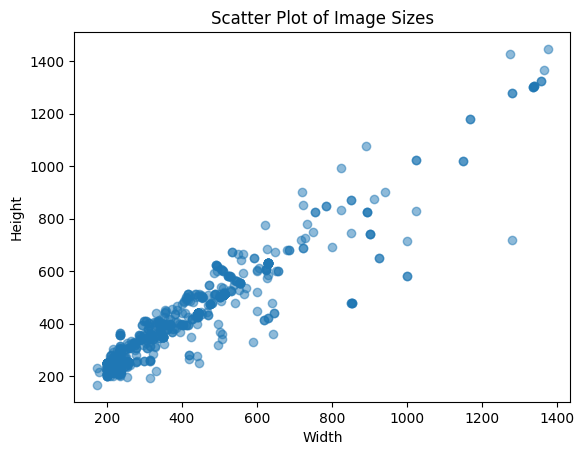

In [14]:
def get_image_sizes(directory):
    sizes = []
    for filename in os.listdir(directory):
        path = os.path.join(directory, filename)
        img = cv2.imread(path)
        height, width, _ = img.shape
        sizes.append((width, height))
    return sizes

image_directories = ["/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor",
                    "/kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor",
                    "/kaggle/input/brain-tumor-classification-mri/Testing/no_tumor",
                    "/kaggle/input/brain-tumor-classification-mri/Testing/pituitary_tumor",
                    "/kaggle/input/brain-tumor-classification-mri/Training/glioma_tumor",
                    "/kaggle/input/brain-tumor-classification-mri/Training/meningioma_tumor",
                    "/kaggle/input/brain-tumor-classification-mri/Training/no_tumor",
                    "/kaggle/input/brain-tumor-classification-mri/Training/pituitary_tumor"]
sizes = []
for di in image_directories:
    sizes.extend(get_image_sizes(di))

# Separate widths and heights for visualization
widths = [size[0] for size in sizes]
heights = [size[1] for size in sizes]

plt.scatter(widths, heights, alpha=0.5)
plt.title('Scatter Plot of Image Sizes')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()